In [14]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import tensorflow as tf

A recurrent neural network looks very much like a feedforward neural network, except it also has connections pointing backward.

Each recurrent neuron has two sets of weights: one for the inputs x and
the other for the outputs of the previous time step y

we will look at some more complex
and powerful types of cells capable of learning longer patterns

<img src="https://www.researchgate.net/profile/Vidushi-Mishra/publication/324883736/figure/fig2/AS:621644821307392@1525223083712/Recurrent-neural-networkRNN-or-Long-Short-Term-MemoryLSTM-5616.png" width=400px/>

### Generate the Dataset

In [15]:
def generate_time_series(batch_size, n_steps) :
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)

    # each series is the sum of two sine waves of fixed amplitudes but random 
    # frequencies and phases, plus a bit of noise
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32) # [batch size, time steps, 1]

In [16]:
generate_time_series(10, 2).shape

(10, 2, 1)

In [17]:
np.random.seed(42)

n_steps = 50
batch_size = 10000
series = generate_time_series(batch_size, n_steps+1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1] # predict the last one
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [18]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

In [19]:
def plot_series(series, y=None, y_pred=None, x_label='$t$', y_label='$x(t)$', legend=True):
    plt.plot(series, '.-')
    plt.grid(True)
    
    if y :
        plt.plot(n_steps, y, 'bo', label='Target')
    if y_pred :
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    
    
    if x_label :
        plt.xlabel(x_label, fontsize=16)
    if y_label :
        plt.ylabel(y_label, fontsize=16, rotation=0)


    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

In [20]:
X_valid[0,:,0].shape # for each x instance

(50,)

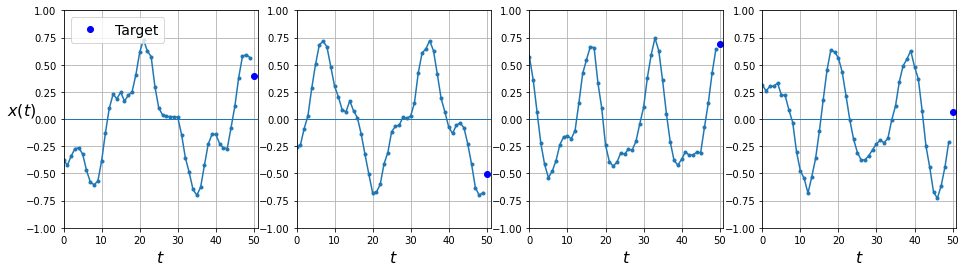

In [21]:
plt.figure(figsize=(16,4))
for col in range(4) :
    plt.subplot(1,4,col+1)
    plot_series(X_valid[col, :, 0], y_valid[col, 0], 
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))

### Baseline Metrics 
Before we start using RNNs, it is often a good idea to have a few baseline
metrics : using **naive forcasting** concept is today is same as the yesterday, tomorrow same as today.

In [22]:
y_pred = X_valid[:, -1] # predict from the last value of x
baseline_mse = np.mean(np.square(y_pred - y_valid))
baseline_mse

0.020211367

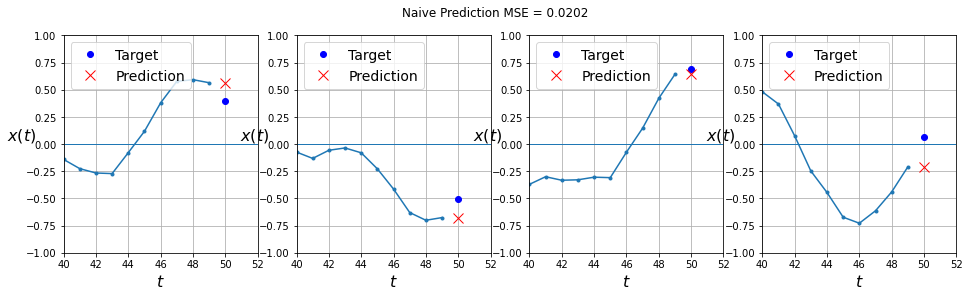

In [23]:
plt.figure(figsize=(16,4))
for sample in range(4) :
    plt.subplot(1,4,sample+1)
    plot_series(X_valid[sample, :, 0], y_valid[sample, 0], y_pred[sample, 0])
    plt.xlim([40,52])
    plt.suptitle(f'Naive Prediction MSE = {baseline_mse:.4f}')

## Implementing a Simple RNN

In [24]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.Sequential([ 
    keras.layers.Input(shape=(50,1)),
    keras.layers.SimpleRNN(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss='mse', optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 4s 12ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0116 - val_loss: 0.

In [25]:
model_1_mse = model.evaluate(X_valid, y_valid)
model_1_mse

63/63 [==============================] - 0s 4ms/step - loss: 0.0109


0.010881561785936356

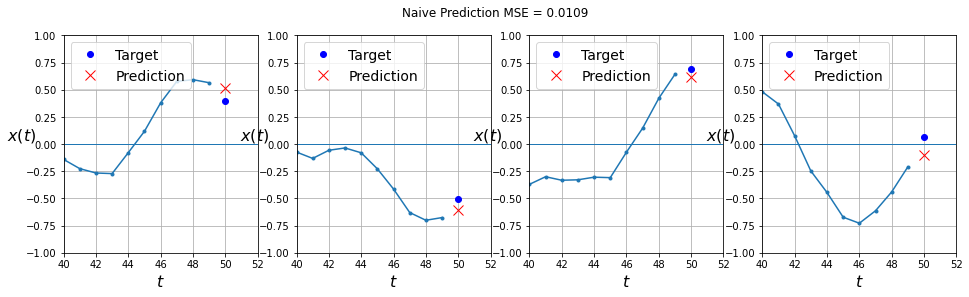

In [26]:
y_pred = model.predict(X_valid)
plt.figure(figsize=(16,4))
for sample in range(4) :
    plt.subplot(1,4,sample+1)
    plot_series(X_valid[sample, :, 0], y_valid[sample, 0], y_pred[sample, 0])
    plt.xlim([40,52])
    plt.suptitle(f'Naive Prediction MSE = {model_1_mse:.4f}')

## Deep RNNs 
stack multiple layers of cells

In [27]:
np.random.seed(42)
tf.random.set_seed(42)

model_2 = keras.models.Sequential([ 
    keras.layers.Input(shape=(50,1)),
    keras.layers.SimpleRNN(20, return_sequences=True), # if stack need to return_sequences
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model_2.compile(loss='mse', optimizer='adam')
history_2 = model_2.fit(X_train, y_train, epochs=20,
                        validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 12s 39ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 8s 35ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 8s 35ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 8s 34ms/step - loss: 0.0035 - val_l

In [28]:
model_2_mse = model_2.evaluate(X_valid, y_valid)
model_2_mse

63/63 [==============================] - 1s 10ms/step - loss: 0.0029


0.0029105644207447767

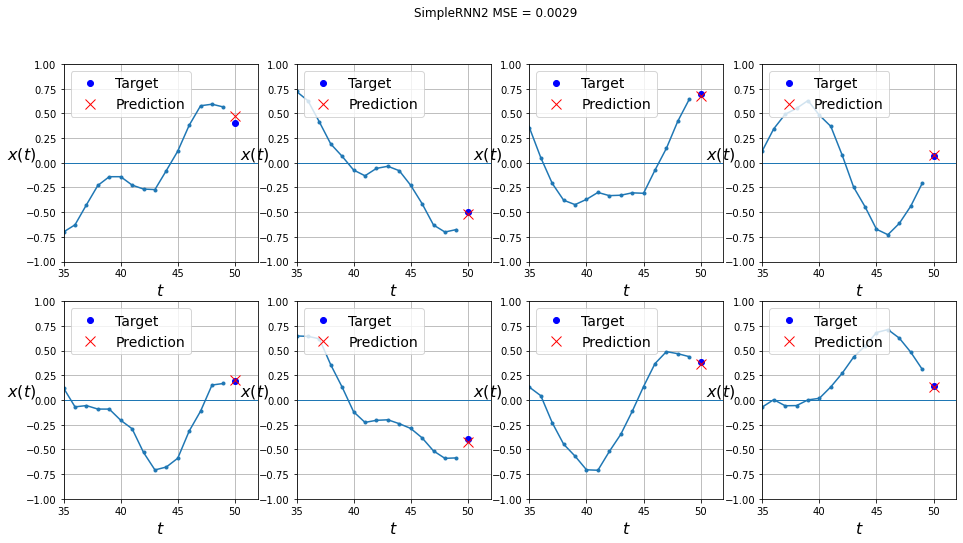

In [29]:
y_pred = model_2.predict(X_valid)
plt.figure(figsize=(16,8))
for sample in range(8) :
    plt.subplot(2,4,sample+1)
    plot_series(X_valid[sample, :, 0], y_valid[sample, 0], y_pred[sample, 0])
    plt.xlim([35,52])
    plt.suptitle(f'SimpleRNN2 MSE = {model_2_mse:.4f}')

> if predict just one is easy, we will make it harder

## Forecasting Several Steps Ahead

In [30]:
np.random.seed(7) # not 42

series = generate_time_series(1, n_steps+10)
series.shape # batch, x, dimention

(1, 60, 1)

In [31]:
X_new, y_true = series[:, :n_steps], series[:, n_steps:] # y is followed x
X = X_new
for next_step in range(10) :
    y_pred_one = model_2.predict(X[:, next_step:])[:, np.newaxis, :] # [0:], [1:], [2:] ... [10:]
    X = np.concatenate([X, y_pred_one], axis=1) # then concat the use the recently predicted y to predict next y 

y_pred = X[:, n_steps:] 

In [32]:
y_pred.shape

(1, 10, 1)

In [78]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1] # x data
    ahead = Y.shape[1] # y next predict
    plot_series(X[0,:, 0]) # first 50 x 
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0] , "bo-", label="Actual", markersize=5)
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=5)
    plt.axis([35, n_steps + ahead, -1, 1]) # n_steps = 50
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, y_true, y_pred)

Now let's use this model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.

In [34]:
np.random.seed(42)

n_steps = 50
batch_size = 10000
series = generate_time_series(batch_size, n_steps+10) # let's make 10 prediction per time
X_train, y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [35]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 10))

In [36]:
np.random.seed(42)
tf.random.set_seed(42)

inputs = keras.Input(shape=(50,1))
x = keras.layers.SimpleRNN(20, return_sequences=True)(inputs)
x = keras.layers.SimpleRNN(20)(x)
outputs = keras.layers.Dense(10)(x)

model_ = keras.Model(inputs, outputs)
model_.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 50, 20)            440       
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense (Dense)               (None, 10)                210       
                                                                 
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


In [37]:
model_.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.001))
history = model_.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 7s 17ms/step - loss: 0.0669 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0265 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0183 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0155 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0139 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0128 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0115 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0110 - val_lo

In [38]:
# make prediction
series = generate_time_series(1, 50+10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model_.predict(X_new)[..., np.newaxis]

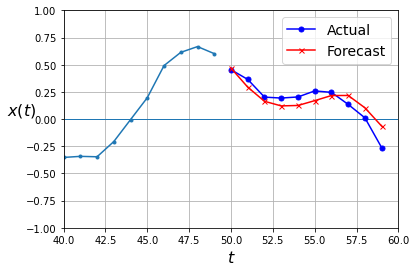

In [40]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.xlim([40,60]);

## Deep RNNs with Layer Norm

- keras.layers.SimpleRNN, a fully-connected RNN where the output from previous timestep is to be fed to next timestep.

You can also define your own RNN cell layer (the inner part of the for loop) with custom behavior, and use it with the generic keras.layers.RNN layer (the for loop itself). This allows you to quickly prototype different research ideas in a flexible way with minimal code.

In [41]:
from tensorflow.keras.layers import LayerNormalization

In [57]:
class LNSimpleRNNCell(keras.layers.Layer) :
    def __init__(self, units, activation='tanh', **kwargs) :
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None) :
        if inputs :
            batch_size = tf.shape(inputs)[0]
            dtype = input.dtype
        return [ tf.zeros([batch_size, self.state_size], dtype=dtype) ]
    
    def call(self, inputs, states) : # run when we call the class
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs)) # put output to normalize layer
        return norm_outputs, [norm_outputs]

> Batch Normalization cannot be used as efficiently with RNNs as with deep feedforward nets. In fact, you cannot use it between time steps, only between recurrent layers. To be more precise, it is technically possible to add a BN layer to a memory cell (as we will see shortly)

> The cell is the inside of the for loop of a RNN layer. Wrapping a cell inside a keras.layers.RNN layer gives you a layer capable of processing batches of sequences, e.g. RNN(LSTMCell(10)).

> Mathematically, RNN(LSTMCell(10)) produces the same result as LSTM(10)

In [58]:
np.random.seed(42)
tf.random.set_seed(42)

inputs = keras.Input(shape=(50,1))
x = keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True)(inputs)
x = keras.layers.RNN(LNSimpleRNNCell(20))(x)
outputs = keras.layers.Dense(10)(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 50, 1)]           0         
                                                                 
 rnn_16 (RNN)                (None, 50, 20)            480       
                                                                 
 rnn_17 (RNN)                (None, 20)                860       
                                                                 
 dense_9 (Dense)             (None, 10)                210       
                                                                 
Total params: 1,550
Trainable params: 1,550
Non-trainable params: 0
_________________________________________________________________


In [59]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 10s 31ms/step - loss: 0.2034 - val_loss: 0.1179
Epoch 2/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0894 - val_loss: 0.0598
Epoch 3/20
219/219 [==============================] - 10s 45ms/step - loss: 0.0469 - val_loss: 0.0404
Epoch 4/20
219/219 [==============================] - 13s 57ms/step - loss: 0.0394 - val_loss: 0.0392
Epoch 5/20
219/219 [==============================] - 13s 61ms/step - loss: 0.0347 - val_loss: 0.0323
Epoch 6/20
219/219 [==============================] - 13s 60ms/step - loss: 0.0296 - val_loss: 0.0276
Epoch 7/20
219/219 [==============================] - 13s 61ms/step - loss: 0.0275 - val_loss: 0.0259
Epoch 8/20
219/219 [==============================] - 13s 61ms/step - loss: 0.0262 - val_loss: 0.0250
Epoch 9/20
219/219 [==============================] - 13s 61ms/step - loss: 0.0254 - val_loss: 0.0252
Epoch 10/20
219/219 [==============================] - 13s 61ms/step - loss: 0.0262

## Tackling the Short-Term Memory Problem

### LSTMs

In [76]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Input(shape=(50,1)),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.LSTM(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam") 
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 18s 62ms/step - loss: 0.0629 - val_loss: 0.0396
Epoch 2/20
219/219 [==============================] - 12s 54ms/step - loss: 0.0327 - val_loss: 0.0257
Epoch 3/20
219/219 [==============================] - 12s 53ms/step - loss: 0.0223 - val_loss: 0.0205
Epoch 4/20
219/219 [==============================] - 12s 54ms/step - loss: 0.0195 - val_loss: 0.0201
Epoch 5/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0179 - val_loss: 0.0170
Epoch 6/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0163 - val_loss: 0.0162
Epoch 7/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0157 - val_loss: 0.0150
Epoch 8/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0148 - val_loss: 0.0139
Epoch 9/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0140 - val_loss: 0.0136
Epoch 10/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0137 - va

In [97]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1] # x data
    ahead = Y.shape[1] # y next predict
    plot_series(X[0,:, 0]) # first 50 x 
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0] , "bo-", label="Actual", markersize=5)
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=5)
    plt.axis([35, n_steps + ahead, -1, 1]) # n_steps = 50
    plt.legend(fontsize=14)

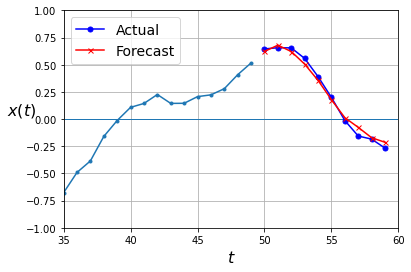

In [106]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]
plot_multiple_forecasts(X_new, Y_new, Y_pred)

### GRUs

In [107]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Input(shape=(50,1)),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam") 
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 18s 65ms/step - loss: 0.0687 - val_loss: 0.0420
Epoch 2/20
219/219 [==============================] - 14s 64ms/step - loss: 0.0388 - val_loss: 0.0352
Epoch 3/20
219/219 [==============================] - 14s 64ms/step - loss: 0.0328 - val_loss: 0.0303
Epoch 4/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0290 - val_loss: 0.0266
Epoch 5/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0239 - val_loss: 0.0206
Epoch 6/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0164 - val_loss: 0.0139
Epoch 7/20
219/219 [==============================] - 14s 66ms/step - loss: 0.0132 - val_loss: 0.0126
Epoch 8/20
219/219 [==============================] - 14s 64ms/step - loss: 0.0117 - val_loss: 0.0117
Epoch 9/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0106 - val_loss: 0.0100
Epoch 10/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0108 

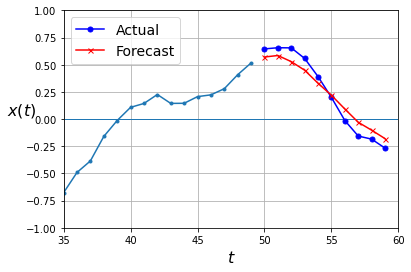

In [108]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

plot_multiple_forecasts(X_new, Y_new, Y_pred)

## Using One-Dimensional Convolutional Layers to Process Sequences

In [109]:
np.random.seed(42)
tf.random.set_seed(42)

inputs = keras.Input(shape=(50,1))
x = keras.layers.Conv1D(filters=20, kernel_size=4, strides=1, padding='valid')(inputs)
x = keras.layers.GRU(20, return_sequences=True)(x)
x = keras.layers.GRU(20)(x)
outputs = keras.layers.Dense(10)(x)

model = keras.Model(inputs, outputs)
model.compile(loss="mse", optimizer="adam") 
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

219/219 [==============================] - 9s 42ms/step - loss: 0.0094 - val_loss: 0.0106
Epoch 13/20
219/219 [==============================] - 9s 42ms/step - loss: 0.0093 - val_loss: 0.0090
Epoch 14/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0092 - val_loss: 0.0088
Epoch 15/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0090 - val_loss: 0.0085
Epoch 16/20
219/219 [==============================] - 10s 46ms/step - loss: 0.0088 - val_loss: 0.0083
Epoch 17/20
219/219 [==============================] - 14s 64ms/step - loss: 0.0089 - val_loss: 0.0081
Epoch 18/20
219/219 [==============================] - 14s 64ms/step - loss: 0.0089 - val_loss: 0.0081
Epoch 19/20
219/219 [==============================] - 14s 63ms/step - loss: 0.0089 - val_loss: 0.0094
Epoch 20/20
219/219 [==============================] - 14s 64ms/step - loss: 0.0087 - val_loss: 0.0090


In [165]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 50, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 47, 20)            100       
                                                                 
 gru_2 (GRU)                 (None, 47, 20)            2520      
                                                                 
 gru_3 (GRU)                 (None, 20)                2520      
                                                                 
 dense_20 (Dense)            (None, 10)                210       
                                                                 
Total params: 5,350
Trainable params: 5,350
Non-trainable params: 0
_________________________________________________________________


In [133]:
input_ = X_train[0,:10]
conv1d = keras.layers.Conv1D(filters=20, kernel_size=4, strides=1, padding='valid')(input_[np.newaxis,...])
print(input_, input_.shape, conv1d.shape)

[[ 0.4596948 ]
 [ 0.33874455]
 [ 0.18980233]
 [ 0.00611999]
 [-0.19590542]
 [-0.38614848]
 [-0.5440984 ]
 [-0.62904716]
 [-0.6633958 ]
 [-0.65724516]] (10, 1) (1, 7, 20)


> kernel_size = 4 stride = 1, --> 7 from (4,5,6,7,8,9,10) -- 7

In [164]:
print(conv1d[:,:,0].numpy().reshape(-1,1)) # first filters

[[ 0.09891575]
 [ 0.08332825]
 [ 0.05595324]
 [ 0.02013205]
 [-0.02518545]
 [-0.0618617 ]
 [-0.08766185]]
